Цель проекта:  
Необходимо создать модель, которая могла бы оценивать риск ДТП при движении по выбранному маршруту. Под риском понимается вероятность ДТП с любым повреждением транспортного средства. Для реализации были предоставлены исторические данные о ДТП одного из регионов.  
Задачи:  
Проанализировать данные  
Построить модель на основе рекомндаций заказчика  
Выделить наиболее важные факторы для модели
Дать рекомендации, возможно ли создать систему риска при выдачи авто. Как нужно оборудовать машину, чтобы учитывать факторы влияюшие на риск.

Содержание проекта:
1. [Подключение к базе данных](#1) Подключение к базе данных, проверка, что подключение прошло.
2. [Первичное исследование таблиц](#2)
   * [Все ли таблицы имеют набор данных](#2a)
   * [Соответствует ли количество таблиц условию задачи](#2b)
   * [Имеется ли общий ключ для связи таблиц](#2c)
3. [Проведение статистического анализа факторов ДТП](#3)
   * [Количество аварий по месяцам в течение года](#3a)
   * [Месяц с наибольшим количеством аварий](#3b)
   * [Формулировка шести аналитическиз задач для группы](#3c)
   * [Решение двух задач из списка](#3d)
     * [Связь серьезности ДТП с возрастом автомобиля](#3da)
     * [Связь между временем ДТП и алкогольным опьянением участника ДТП](#3db)
4. [Модель для оценки водительского риска](#4)
   * [Подготовка набора данных](#4a)
   * [Изучение отобранных признаков](#4b)
   * [Вывод из подготовки данных](#4c)
   * [Корреляционный анализ](#4d)
   * [ВАЖНЫЙ ВЫВОД](#4e)
5. [Обучение моделей](#5)
6. [Матрица ошибок](#6)
7. [Анализ важности факторов ДТП](#7)
   * [Признак местоположения ДТП](#7a)
   * [Рекомендации](#7b)
8. [Выводы](#8)
 

In [1]:
# Импорт необходимых библиотек

# работа с SQL
from sqlalchemy import create_engine
from sqlalchemy import inspect

# работа с данными и визуализация
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

# статистика
from scipy.stats import linregress

# корреляция
import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

# методы кодирования
from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import TargetEncoder
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import MinMaxScaler


# подготовка модели
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# модели
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
import lightgbm as lgb

# перебор параметров
from sklearn.model_selection import GridSearchCV

# метрики качества
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_recall_curve

## Подключаемся к базе.<a id='1'></a> Загружаем таблицы sql

In [2]:
# данные для авторизации
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 
# формирование строки для подлючения
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 
# соединение с базой данных
engine = create_engine(connection_string)

Проверим, что подключение к базе данных работает. Для этого выведем список всех таблиц, используя inspectror.

In [3]:
inspector = inspect(engine)
tables = inspector.get_table_names()
print("Список таблиц:", tables)

Список таблиц: ['collisions', 'case_ids', 'parties', 'vehicles']


Названия таблиц соответствуют заявленым. К базе данных подключились.

## Первичное исследование таблиц <a id='2'></a> 

### Список всех таблиц базы <a id='2a'></a> 

Еще раз изучим список всех таблиц, но используя sql запрос, а не inspector.

In [4]:
# сохраним запрос в переменную
table_list = '''
SELECT table_name 
FROM information_schema.tables 
WHERE table_schema = 'public';
'''
# результат запишем в dataframe
table_list_df = pd.read_sql_query(table_list, con = engine)

print(table_list_df)

   table_name
0    case_ids
1  collisions
2     parties
3    vehicles


В базе данных четыре таблицы: 
* case_ids
* collisions (информация о происшествиях)
* Parties (описание участников происшествия)
* Vehicles (описание автомобиля)

### Столбцы и типы данных в таблицах <a id='2b'></a> 

Теперь проверим, какие данные есть в таблицах.

In [5]:
table_inform_case_ids = '''
SELECT column_name, 
       data_type
FROM information_schema.columns
WHERE table_name = 'case_ids'
'''
table_inform_collisions = '''
SELECT column_name, 
       data_type
FROM information_schema.columns
WHERE table_name = 'collisions'
'''
table_inform_parties = '''
SELECT column_name, 
       data_type
FROM information_schema.columns
WHERE table_name = 'parties'
'''
table_inform_vehicles = '''
SELECT column_name, 
       data_type
FROM information_schema.columns
WHERE table_name = 'vehicles'
'''

In [6]:
# результат запишем в dataframe
table_inform_case_ids_df = pd.read_sql_query(table_inform_case_ids, con = engine)
table_inform_collisions_df = pd.read_sql_query(table_inform_collisions, con = engine)
table_inform_parties_df = pd.read_sql_query(table_inform_parties, con = engine)
table_inform_vehicles_df = pd.read_sql_query(table_inform_vehicles, con = engine)

print(f"case_id:\n{table_inform_case_ids_df}\n\n"
      f"Информация о происшествиях:\n{table_inform_collisions_df}\n\n" 
      f"Описание участников происшествия:\n{table_inform_parties_df}\n\n" 
      f"Описание автомобиля:\n{table_inform_vehicles_df}\n\n")

case_id:
  column_name data_type
0     case_id      text
1     db_year      text

Информация о происшествиях:
                    column_name               data_type
0                   party_count                 integer
1                  intersection                 integer
2                      distance                    real
3                collision_date                    date
4                collision_time  time without time zone
5                 location_type                    text
6              collision_damage                    text
7                       case_id                    text
8        pcf_violation_category                    text
9             type_of_collision                    text
10  motor_vehicle_involved_with                    text
11                 road_surface                    text
12             road_condition_1                    text
13                     lighting                    text
14               control_device                   

Во всех четырех таблицах есть данные, количество столбцов совпадает с предоставленным описанием базы данных. Типы данных очень разные, большая часть данных представлена типом text (строки с неограниченной длинной).

### Общий ключ между таблицами <a id='2c'></a> 

Найдем общий ключ, который объединяет таблицы.

In [7]:
table_key ='''
SELECT conrelid::regclass AS table_1,
       conname AS constraint_name,
       confrelid::regclass AS table_2
FROM pg_constraint
WHERE contype = 'f'; 
'''
table_key_df = pd.read_sql_query(table_key, con = engine)
table_key_df

,table_1,constraint_name,table_2
0,collisions,collisions_case_ids_case_id_fk,case_ids
1,parties,parties_case_ids_case_id_fk,case_ids
2,vehicles,vehicles_case_ids_case_id_fk,case_ids


Все таблицы объединены с таблицей case_id через столбец case_id. Case_id является первичным ключом.

##   Статистический анализ факторов ДТП <a id='3'></a> 

### Количество аварий по месяцам в течение года <a id='3a'></a> 

Проанализируем весь период наблюдений и установим, в какие месяцы происходит наибольшее количество аварий.  
Для этого создадим SQL запрос к таблице collisions. Сформируем DataFrame и построим график, используя средства python.
Сделаем два SQL запроса: 
* Первым посмотрим динамику аварий по годам от месяца к месяцу.
* Второым запросом выведем среднее количество аварий в каждый месяц за все время наблюдений.

In [8]:
year_month = '''
SELECT CAST(DATE_TRUNC('month', collision_date) AS DATE) AS year_month,
       COUNT(*) AS accident_count
FROM collisions
GROUP BY year_month
ORDER  BY year_month;
'''
year_month_stat = pd.read_sql_query(year_month, con = engine)

In [9]:
year_month_stat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   year_month      56 non-null     object
 1   accident_count  56 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.0+ KB


In [10]:
year_month_stat.head(56)

,year_month,accident_count
0,2009-01-01,35062
1,2009-02-01,34480
2,2009-03-01,36648
3,2009-04-01,35239
4,2009-05-01,36916
5,2009-06-01,34202
6,2009-07-01,35161
7,2009-08-01,34508
8,2009-09-01,35555
9,2009-10-01,37835


В данных представлены 2009, 2010, 2011, 2012, 2013, 2020 годы, при этом для 2020 года есть только две записи. Количество записей резко падает в 2012 году. График будем строить без учета 2013 и 2020 года

In [11]:
year_month_stat_filt = year_month_stat.loc[year_month_stat['accident_count'] >4000]

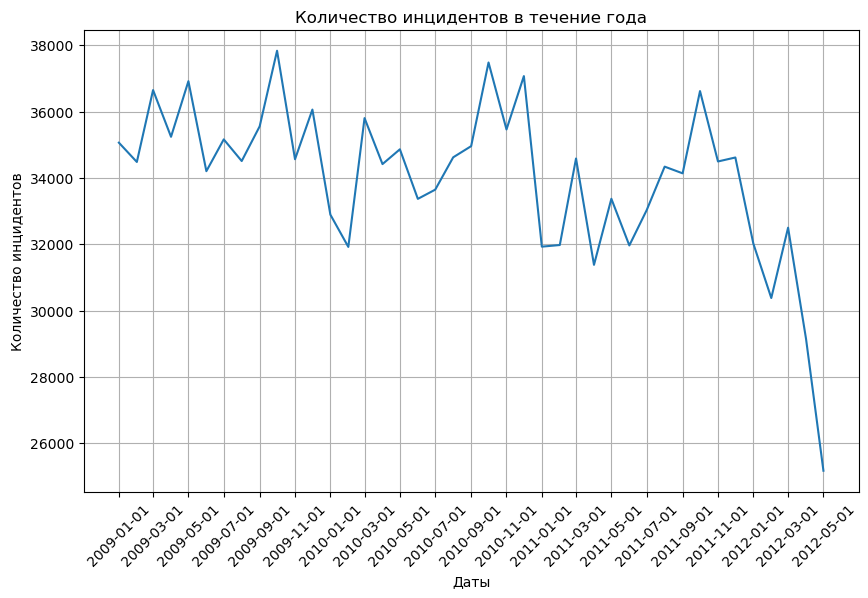

In [12]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(year_month_stat_filt['year_month'], year_month_stat_filt['accident_count'])
ax.set_xlabel('Даты')
ax.set_ylabel('Количество инцидентов')
ax.set_title('Количество инцидентов в течение года')
ax.set_xticks(year_month_stat_filt['year_month'][::2])
ax.set_xticklabels(year_month_stat_filt['year_month'][::2], rotation=45)
ax.grid()
plt.show()

Из графика видно, что динамика количества ДТП присутствует. Наблюдается увеличение инцидентов в октябре и падение в декабре-январе.

### Месяц с наибольшим количеством аварий <a id='3b'></a> 

Вторым запросом выведем среднее количество аварий в каждый месяц за все время наблюдений. Изначально предполагалось использовать все данные, но 2013 и 2020 годы содержат очень мало значений и не все месяцы. А в данных 2012 года наблюдается падение от месяца к месяцу, поэтому будем использовать только 2009, 2010, 2011 годы.

In [13]:
collis_per_month ='''
SELECT EXTRACT(MONTH FROM collision_date) AS month,
       COUNT(*) / COUNT(DISTINCT EXTRACT(YEAR FROM collision_date)) AS collis_per_month
FROM collisions
WHERE EXTRACT(YEAR FROM collision_date) <= 2011
GROUP BY month
ORDER BY collis_per_month DESC;
'''
av_collis_per_month = pd.read_sql_query(collis_per_month, con = engine)

In [14]:
av_collis_per_month.head(12)

,month,collis_per_month
0,10.0,37311
1,12.0,35915
2,3.0,35678
3,5.0,35049
4,9.0,34883
5,11.0,34839
6,8.0,34489
7,7.0,33945
8,4.0,33677
9,1.0,33293


In [15]:
av_collis_per_month = av_collis_per_month.sort_values(by = 'month')

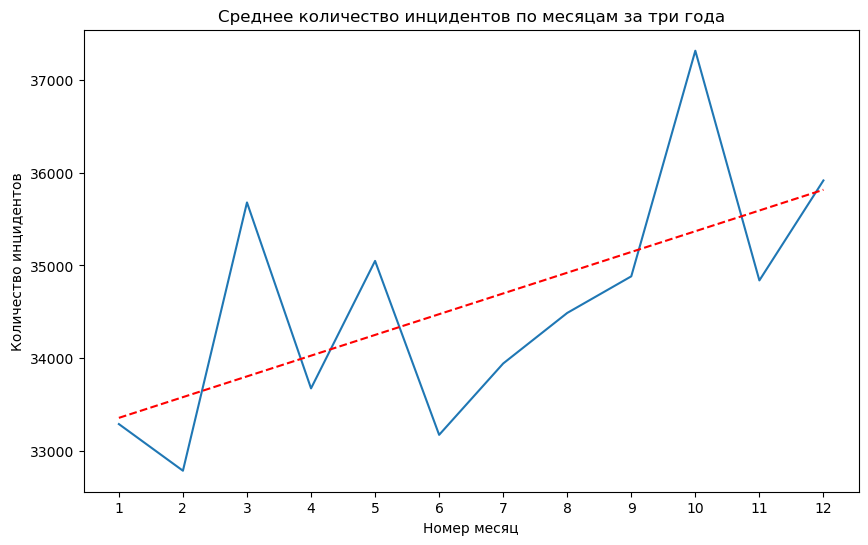

Наклон линии регресии:  223.15734265734267 +- 90.66706447367132


In [16]:
slope, intercept, r_value, p_value, std_err = linregress(av_collis_per_month['month'], av_collis_per_month['collis_per_month'])
trend_line = av_collis_per_month['month'] * slope + intercept

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(av_collis_per_month['month'], av_collis_per_month['collis_per_month'])
ax.plot(av_collis_per_month['month'], trend_line, linestyle='--', color='red', label="Линия тренда")
ax.set_xlabel('Номер месяц')
ax.set_ylabel('Количество инцидентов')
ax.set_title('Среднее количество инцидентов по месяцам за три года')
ax.set_xticks(av_collis_per_month['month'])
plt.show()

print("Наклон линии регресии: ", slope,"+-", std_err)

В среднем за три года наибольшее количество аварий происходит в октябре. Линия регрессии показывает положительный наклон, из этого можно сделать вывод о том, что количество инцидентов увеличивается в течение года.

### Аналитические задачи для группы <a id='3c'></a> 

Сформулируем шесть задач:
1. Изучить время происшествия и серьезность происшествий. Совпадает ли время наибольшего числа происшетсвий с часом пик. Теоритически наибольшее количество аварий должно приходится на час пик, так как поток автотранспорта больше, но при этом серьезность происшетсвий может быть ниже, так как скорости движения минимальны.
2. Связано ли серьезность происшествия с возрастом автомобиля. Чем старше автомобиль, тем менее современными системами контроля движения он оснащен.
3. Сколько аварий происходит на перекрестках и сколько участников в таких авариях. Данное предположение искодит из того, что проезд перекрестка наиболее опасный момент во время движения.
4. Важно оценить количество и серьезность происшествий от опьянения и состояния водителя.
5. Представляет интерес оценить, в какое время количество ДТП с участием пьяного водителя выше. Необходимо связать время инцидента и трезвость участника ДТП.
6. Важным фактором риска являются погодные условия. Необходимо оценить количество и серьезность ДТП от погодных условий.

### Решение двух задач из списка <a id='3d'></a> 

Решим две задачи самостоятельно. Возьмем вторую и пятую задачи.

#### Связь серьезности ДТП с возрастом автомобиля <a id='3da'></a> 

Для того, чтобы решить эту задачу необходимо: 
* составить SQL запрос, который объединит таблицы collisions и vehicles и выведет серьезность происшествия в зависимости от возраста автомобиля
* перевести полученный результат в DataFrame
* рассчитать среднее значение возраста автомобиля и стандартное отклонение
* построить столбчатую диаграмму

In [17]:
damage_age = '''
SELECT c.collision_damage,
       v.vehicle_age
FROM collisions AS c
JOIN vehicles AS v ON c.case_id = v.case_id;
'''

collision_damage_vehicle_age = pd.read_sql_query(damage_age, con = engine)

Запрос, который выведет все данные, а не среднее, необходим для расчета стандартного отклонения.

In [18]:
collision_damage_vehicle_age.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1021234 entries, 0 to 1021233
Data columns (total 2 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   collision_damage  1021234 non-null  object 
 1   vehicle_age       996652 non-null   float64
dtypes: float64(1), object(1)
memory usage: 15.6+ MB


In [19]:
collision_damage_vehicle_age_cl = collision_damage_vehicle_age.dropna()

In [20]:
collision_damage_vehicle_age_cl.groupby('collision_damage')['vehicle_age'].describe()

,count,mean,std,min,25%,50%,75%,max
collision_damage,,,,,,,,
fatal,15015.0,6.391475,6.124866,0.0,3.0,6.0,8.0,161.0
middle damage,218608.0,5.205075,3.025386,0.0,3.0,5.0,7.0,20.0
scratch,451294.0,5.539551,2.933358,0.0,3.0,5.0,8.0,20.0
severe damage,40648.0,5.471561,2.960857,0.0,3.0,5.0,8.0,16.0
small damage,271087.0,4.292629,3.062424,0.0,2.0,3.0,6.0,18.0


Из анализа описательной статистики видно, что медиана и среднее значение почти во всех случаях совпадают. Правда встречается максимальное значение возраста в 161 год, что явно неверное значение.  
Ограничем данные, убрав очень большие значения.

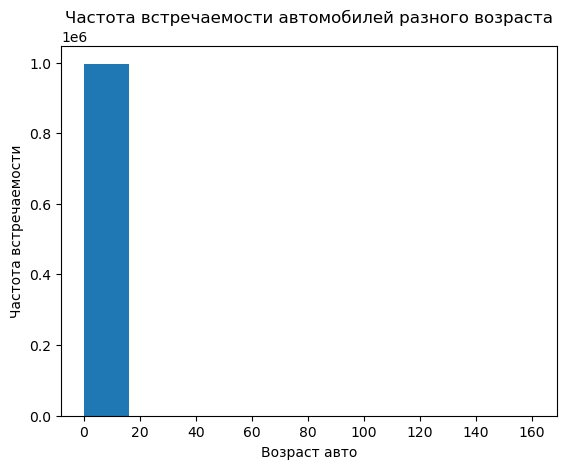

In [21]:
plt.hist(collision_damage_vehicle_age_cl['vehicle_age'], bins=10)
plt.xlabel('Возраст авто')
plt.ylabel('Частота встречаемости')
plt.title('Частота встречаемости автомобилей разного возраста')
plt.show()

Ограничим данные 20 годами.

In [22]:
collision_damage_vehicle_age_cl_filt = collision_damage_vehicle_age_cl.loc[
(collision_damage_vehicle_age_cl['vehicle_age']<15)]

In [23]:
collision_damage_vehicle_age_av = collision_damage_vehicle_age_cl_filt.groupby('collision_damage').agg([np.mean, np.std])
collision_damage_vehicle_age_av.columns = ['mean', 'std']
collision_damage_vehicle_age_av.head()

/var/folders/bt/205ky3fd1092qkbczfc383cr0000gn/T/ipykernel_40463/765861005.py:1: FutureWarning: The provided callable <function mean at 0x1040c6280> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  collision_damage_vehicle_age_av = collision_damage_vehicle_age_cl_filt.groupby('collision_damage').agg([np.mean, np.std])
/var/folders/bt/205ky3fd1092qkbczfc383cr0000gn/T/ipykernel_40463/765861005.py:1: FutureWarning: The provided callable <function std at 0x1040c63a0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  collision_damage_vehicle_age_av = collision_damage_vehicle_age_cl_filt.groupby('collision_damage').agg([np.mean, np.std])


,mean,std
collision_damage,,
fatal,6.192405,3.200654
middle damage,5.195190,3.010428
scratch,5.533449,2.924136
severe damage,5.464709,2.950776
small damage,4.282846,3.046031


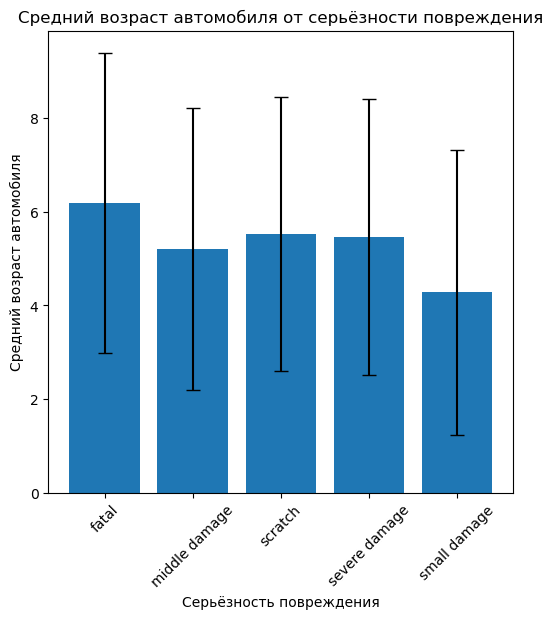

In [24]:
fig, ax = plt.subplots(figsize=(6,6))
ax.bar(collision_damage_vehicle_age_av.index, 
       collision_damage_vehicle_age_av['mean'],
       yerr=collision_damage_vehicle_age_av['std'],
      capsize=5
      )
ax.set_xlabel('Серьёзность повреждения')
ax.set_ylabel('Средний возраст автомобиля')
ax.set_title('Средний возраст автомобиля от серьёзности повреждения')
plt.xticks(rotation=45)
plt.show()
    

Визуально из графика видно, что серьезность повреждения не зависит от возраста автомобиля. Но разброс значений возраста автомобилей большой. В дальнейшем, при необходимости, используя эти данные, можно провести статистический анализ.

#### Связь между временем ДТП и алкогольным опьянением участника ДТП <a id='3db'></a> 

Проверим, в какой временной интервал дня наибольшее количество с участием нетрезвых водителей. Это позволит нам косвенно оценить, в какой промеждуток времени больше нетрезвых водителей.

In [25]:
collision_hour = '''
SELECT 
    EXTRACT(HOUR FROM c.collision_time) AS collision_hour,
    p.party_sobriety,
    COUNT(*) AS accident_count
FROM collisions AS c
JOIN parties AS p ON c.case_id = p.case_id
WHERE p.party_sobriety IS NOT NULL
GROUP BY 
    collision_hour, p.party_sobriety
ORDER BY 
    collision_hour, p.party_sobriety;
'''
collision_hour_party = pd.read_sql_query(collision_hour, con = engine)

In [26]:
collision_hour_party.head(10)

,collision_hour,party_sobriety,accident_count
0,0.0,"had been drinking, impairment unknown",830
1,0.0,"had been drinking, not under influence",835
2,0.0,"had been drinking, under influence",8926
3,0.0,had not been drinking,18327
4,0.0,impairment unknown,6470
5,0.0,not applicable,7114
6,1.0,"had been drinking, impairment unknown",1004
7,1.0,"had been drinking, not under influence",1013
8,1.0,"had been drinking, under influence",10344
9,1.0,had not been drinking,14839


Данные есть, теперь построим график.

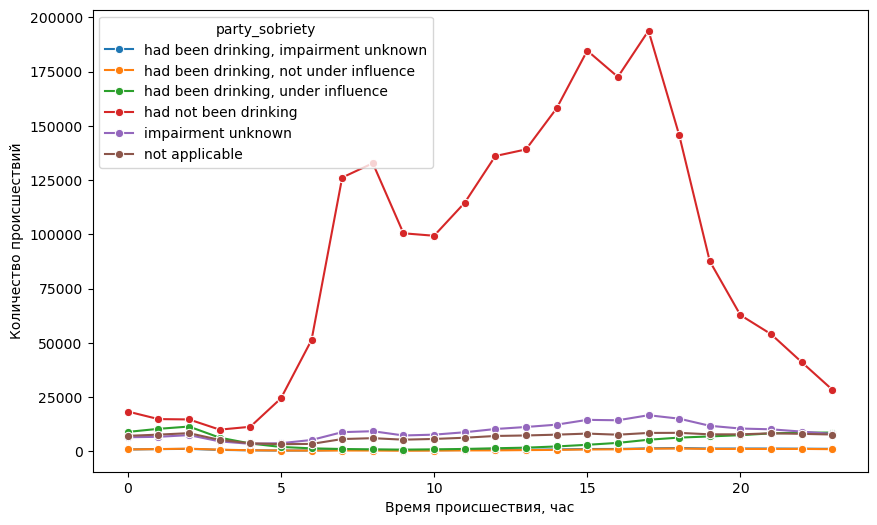

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
sb.lineplot(data=collision_hour_party, 
             x='collision_hour', 
             y='accident_count', 
             hue='party_sobriety', 
             marker='o', 
             ax=ax)
plt.xlabel('Время происшествия, час')
plt.ylabel('Количество происшествий')        
plt.show()

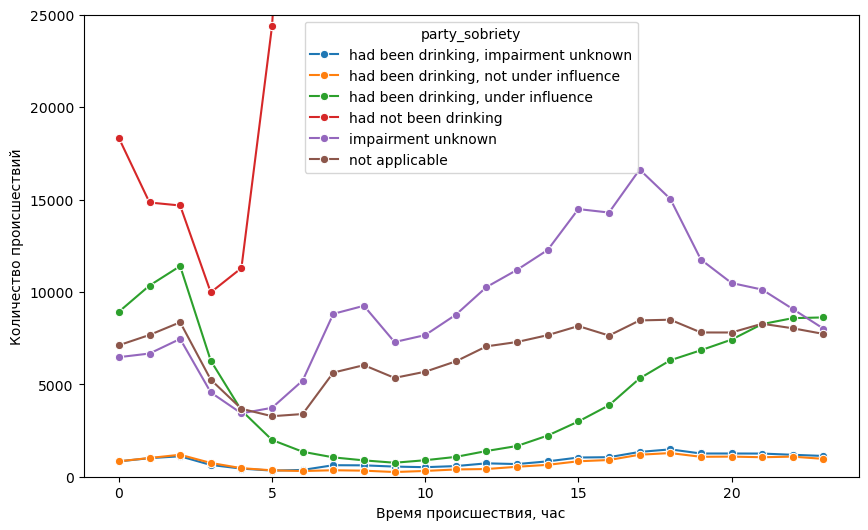

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
sb.lineplot(data=collision_hour_party, 
             x='collision_hour', 
             y='accident_count', 
             hue='party_sobriety', 
             marker='o', 
             ax=ax)
plt.xlabel('Время происшествия, час')
plt.ylabel('Количество происшествий')    
ax.set_ylim(0, 25000)
plt.show()

Два полученных графика позволяют сделать несколько выводов:  
* Наибольшее количество инцидентов с трезвыми водителями приходится на дневные часы, с пиками во временные интервалы часа пик.
* Нетрезвые водители становятся участниками ДТП в вечернее и ночное время.
* Ход кривых для impairment unknown и not applicable дублирует ход кривой had not been drinking. Вероятно, туда попали в осносном трезвые водители.
* Две категории had been drinking, impairment unknown и had been drinking, not under influence содержат мало значений.

## Создайте модель для оценки водительского риска <a id='4'></a> 

### Подготовка набора данных, необходимых для модели <a id='4a'></a> 

Согласно предложению заказчика, данные должны соответствовать следующим критериям:
* Тип виновника ДТП - car
* Все типы поврежденией кроме scratch
* Берем данные только за 2012 год

Составим SQL и создадим DataFrame с соответствующими данными. Объединим таблицы по case_id. К таблице parties присоединим collisions и vehicles. 

In [29]:
data_1 = '''
SELECT *
FROM parties AS p
INNER JOIN collisions AS c ON p.case_id = c.case_id
INNER JOIN vehicles AS v ON p.case_id = v.case_id AND p.party_number = v.party_number
WHERE p.party_type = 'car' 
  AND c.collision_damage != 'scratch'
  AND EXTRACT(YEAR FROM c.collision_date) = 2012;
'''
data = pd.read_sql_query(data_1, con = engine)

In [30]:
data.head()

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,case_id,...,lighting,control_device,collision_date,collision_time,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,2657345,5599684,2,car,0,46.0,had not been drinking,None,0.0,5599684,...,daylight,functioning,2012-04-15,17:05:00,1463713,5599684,2,sedan,auto,2.0
1,2395824,5449062,2,car,0,54.0,had not been drinking,None,0.0,5449062,...,dark with street lights,functioning,2012-01-15,02:00:00,1320506,5449062,2,sedan,manual,10.0
2,2676091,5610553,2,car,0,27.0,had not been drinking,None,NaN,5610553,...,daylight,none,2012-04-29,17:10:00,1473108,5610553,2,sedan,auto,3.0
3,2676152,5610588,2,car,0,52.0,had not been drinking,None,0.0,5610588,...,daylight,none,2012-04-18,17:15:00,1473131,5610588,2,sedan,auto,10.0
4,2694833,5620792,2,car,0,35.0,had not been drinking,None,0.0,5620792,...,daylight,none,2012-05-05,11:00:00,1483908,5620792,2,sedan,auto,2.0


Проверим действительно ли в нашей таблице party_type = car.

In [31]:
data['party_type'].unique()

array(['car'], dtype=object)

Проверим дубликаты.

In [32]:
data.duplicated(subset=data.columns[0]).sum()

0

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           56248 non-null  int64  
 1   case_id                      56248 non-null  object 
 2   party_number                 56248 non-null  int64  
 3   party_type                   56248 non-null  object 
 4   at_fault                     56248 non-null  int64  
 5   insurance_premium            55701 non-null  float64
 6   party_sobriety               55376 non-null  object 
 7   party_drug_physical          2857 non-null   object 
 8   cellphone_in_use             51777 non-null  float64
 9   case_id                      56248 non-null  object 
 10  county_city_location         56248 non-null  object 
 11  county_location              56248 non-null  object 
 12  distance                     56248 non-null  float64
 13  direction       

Таблицы собраны и загружены, теперь проведем первичный отбор факторов, необходимых для модели. Необходимы факторы, которые могли бы влиять на оценку риска ДТП на выбранном маршруте движения.

Не берем в модель:
Признаки, которые описывают уже состоявшиеся ДТП, т.е. эти признаки описывают взгляд в будущее.
* Серьезность происшествия (collision_damage)
* Количество участников (party_count)
* Тип аварии (type_of_collision)
* Дополничельные участники ДТП (motor_vehicle_involved_with)
* Дата происшествия (collision_date)
* сумма страховки (insurance_premium)
* Основной фактор аварии (primary_collision_factor)
* категория нарушения (pcf_violation_category)

Признаки с идентификаторами
* id
* case_id
* party_number
* party_type

In [34]:
data_for_model = data[['county_city_location', #содержат информацию где произошло ДТП
                       'county_location', #скорее всего между эти признками будет мультиколлинеарны
                       'distance', #дистанция от главное дороги
                       'direction', #направление движение
                       'intersection',#является ли место происшествия перекрестком
                       'weather_1', #погода при ДТП
                       'location_type', #тип дороги
                       'road_surface', #состояние дороги в зависимости от погоды
                       'road_condition_1', #дорожное состояние
                       'lighting', #освещение
                       'control_device', #устройство управления
                       'collision_time', #время происшествия
                       'vehicle_transmission', #тип трансмиссии
                       'at_fault', #Виновность участника
                       'cellphone_in_use',#наличие телефона
                       'vehicle_type',#тип кузова
                       'vehicle_age' #возраст автомобиля
                      ]]

In [35]:
data_for_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56248 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  56248 non-null  object 
 1   county_location       56248 non-null  object 
 2   distance              56248 non-null  float64
 3   direction             43230 non-null  object 
 4   intersection          56073 non-null  float64
 5   weather_1             56080 non-null  object 
 6   location_type         25932 non-null  object 
 7   road_surface          55900 non-null  object 
 8   road_condition_1      55999 non-null  object 
 9   lighting              56094 non-null  object 
 10  control_device        56033 non-null  object 
 11  collision_time        56160 non-null  object 
 12  vehicle_transmission  55389 non-null  object 
 13  at_fault              56248 non-null  int64  
 14  cellphone_in_use      51777 non-null  float64
 15  vehicle_type       

### Изучение отобранных признаков <a id='4b'></a> 

#### Номер географических районов, где произошло ДТП

In [36]:
pd.set_option('display.max_rows', None)
data_for_model['county_city_location'].value_counts()

county_city_location
1942    6931
1900    2234
3711    1340
3400    1087
3600    1008
3300     966
3700     954
1500     946
3001     908
4313     894
3404     724
1000     653
3313     528
5400     512
3801     510
3604     496
0109     493
3900     481
3019     478
3607     475
1941     458
3010     421
5000     406
2700     385
1953     357
0100     356
1502     349
5607     337
5604     320
3015     320
3026     316
1005     313
4400     309
1985     306
4900     295
1949     291
1920     289
3009     286
4000     285
3100     284
2400     279
1955     277
0900     273
4200     272
5600     267
2000     251
5002     246
1992     243
3315     241
3616     234
1925     232
0105     226
3024     224
3008     224
3610     221
3710     220
4300     215
3105     213
4905     212
1990     203
3394     202
3706     202
1950     200
1912     198
3004     198
1965     194
5601     194
2100     189
4203     188
0700     188
3022     186
1975     184
1200     182
3905     179
0400     178
4500

In [37]:
data_for_model['county_city_location'].nunique()

496

В признаке 496 уникальных номеров. Очень много номеров встречается малое количество раз. Пока столбец оставим без изменения. Возможно данный признак сильно коррелирует с признаком название района (country_location).

#### Название географического района, где произошло ДТП

In [38]:
data_for_model['county_location'].value_counts()

county_location
los angeles        16236
orange              5364
san diego           3740
san bernardino      3649
riverside           3313
sacramento          2185
alameda             1876
santa clara         1845
ventura             1466
kern                1415
fresno              1073
contra costa         990
san mateo            938
san joaquin          936
stanislaus           805
santa barbara        733
tulare               721
sonoma               692
placer               589
monterey             577
solano               551
san francisco        510
san luis obispo      440
santa cruz           430
merced               395
marin                372
humboldt             330
madera               326
butte                322
el dorado            290
shasta               283
yolo                 281
kings                247
napa                 211
imperial             209
mendocino            194
nevada               184
tehama               150
sutter               144
tuolumne 

In [39]:
data_for_model['county_location'].nunique()

58

В данных 58 уникальных названий районов. Введем порог и объединим все районы, где меньше 1000 значений, в одну категорию other.

In [40]:
data_for_model_2 = data_for_model.copy()

In [41]:
category_counts = data_for_model['county_location'].value_counts()
categories_to_replace = category_counts[category_counts<1000].index
data_for_model_2['county_location'] = data_for_model['county_location'].replace(
                                                 categories_to_replace, 'other')

In [42]:
data_for_model_2['county_location'].value_counts()

county_location
los angeles       16236
other             14086
orange             5364
san diego          3740
san bernardino     3649
riverside          3313
sacramento         2185
alameda            1876
santa clara        1845
ventura            1466
kern               1415
fresno             1073
Name: count, dtype: int64

#### Расстояние от главной дороги (метры)

In [43]:
data_for_model_2['distance'].describe().apply(lambda x: f"{x:,.2f}")

count       56,248.00
mean           859.44
std          7,240.30
min              0.00
25%              7.00
50%            135.00
75%            545.00
max      1,584,000.00
Name: distance, dtype: object

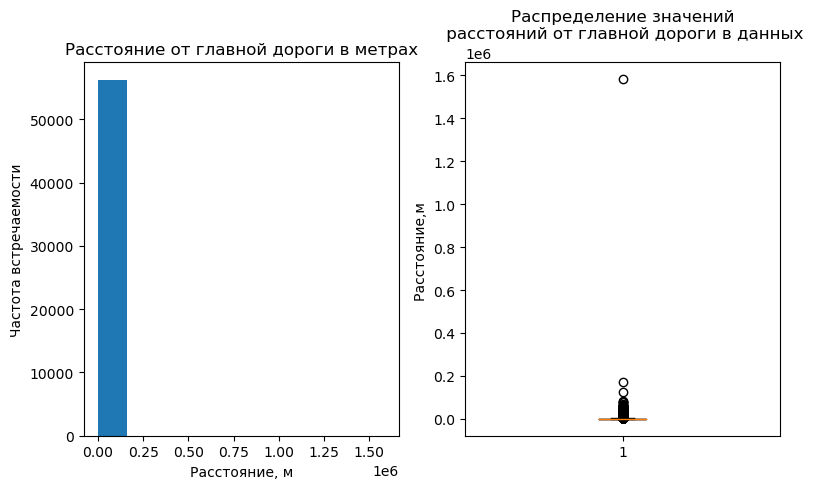

In [44]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].hist(data_for_model_2['distance'], bins=10)
ax[0].set_xlabel('Расстояние, м')
ax[0].set_ylabel('Частота встречаемости')
ax[0].set_title('Расстояние от главной дороги в метрах')
ax[1].boxplot(data_for_model_2['distance'])
ax[1].set_ylabel('Расстояние,м ')
ax[1].set_title('Распределение значений\n расстояний от главной дороги в данных')
plt.tight_layout()
plt.show()  

#### Направления движения

In [45]:
data_for_model_2['direction'].value_counts()

direction
north    12129
south    11884
west      9702
east      9515
Name: count, dtype: int64

In [46]:
data_for_model_2['direction'].isna().sum()

13018

Направление движения в данных представлены примерно в одинаковых количествах, а также ~~28905~~ 13018 пропуска. Заменим пропуски на категорию 'unknown'.

In [47]:
data_for_model_2['direction'] = data_for_model_2['direction'].fillna('unknown')

In [48]:
data_for_model_2['direction'].value_counts()

direction
unknown    13018
north      12129
south      11884
west        9702
east        9515
Name: count, dtype: int64

#### Является ли место происшествия перекрестком.

In [49]:
data_for_model_2['intersection'].value_counts()

intersection
0.0    43651
1.0    12422
Name: count, dtype: int64

In [50]:
data_for_model_2['intersection'].isna().sum()

175

В данных 175 пропусков. В данном случае лучше пожертвовать этими данными и не создавать новую маленькую категорию.

In [51]:
data_for_model_2 = data_for_model_2.dropna(subset=['intersection'])

In [52]:
data_for_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56073 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  56073 non-null  object 
 1   county_location       56073 non-null  object 
 2   distance              56073 non-null  float64
 3   direction             56073 non-null  object 
 4   intersection          56073 non-null  float64
 5   weather_1             55906 non-null  object 
 6   location_type         25907 non-null  object 
 7   road_surface          55729 non-null  object 
 8   road_condition_1      55825 non-null  object 
 9   lighting              55920 non-null  object 
 10  control_device        55866 non-null  object 
 11  collision_time        55985 non-null  object 
 12  vehicle_transmission  55217 non-null  object 
 13  at_fault              56073 non-null  int64  
 14  cellphone_in_use      51653 non-null  float64
 15  vehicle_type          56

#### Погодные условия

In [53]:
data_for_model_2['weather_1'].value_counts()

weather_1
clear      44945
cloudy      8411
raining     2167
fog          181
snowing      157
other         34
wind          11
Name: count, dtype: int64

In [54]:
data_for_model_2['weather_1'].isna().sum()

167

В данных 7 категорий погоды. Больше всего данных категории clear. При таких количественных различиях между категориями можно объединить fog, snowing, wind в категорию other. Пропуски заполнил категорией 'unknown'.

In [55]:
data_for_model_2['weather_1'] = data_for_model_2['weather_1'].replace({'fog':'other',
                                                                       'snowing':'other',
                                                                       'wind':'other'})

In [56]:
data_for_model_2['weather_1'] = data_for_model_2['weather_1'].fillna('unknown')

In [57]:
data_for_model_2['weather_1'].value_counts()

weather_1
clear      44945
cloudy      8411
raining     2167
other        383
unknown      167
Name: count, dtype: int64

#### Тип дороги

In [58]:
data_for_model_2['location_type'].value_counts()

location_type
highway         21308
ramp             3259
intersection     1340
Name: count, dtype: int64

Заполним часть пропусков в location_type, исходя из столбца intersection.

In [59]:
data_for_model_2.loc[
(data_for_model_2['intersection'] == 1) & (data_for_model_2['location_type'].isna()), 
'location_type'
] = 'intersection'

In [60]:
data_for_model_2['location_type'].value_counts()

location_type
highway         21308
intersection    12020
ramp             3259
Name: count, dtype: int64

In [61]:
data_for_model_2['location_type'].isna().sum()

19486

Оставшиеся пропуски заменим на 'unknown'.

In [62]:
data_for_model_2['location_type'] = data_for_model_2['location_type'].fillna('unknown')

In [63]:
data_for_model_2['location_type'].value_counts()

location_type
highway         21308
unknown         19486
intersection    12020
ramp             3259
Name: count, dtype: int64

In [64]:
data_for_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56073 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  56073 non-null  object 
 1   county_location       56073 non-null  object 
 2   distance              56073 non-null  float64
 3   direction             56073 non-null  object 
 4   intersection          56073 non-null  float64
 5   weather_1             56073 non-null  object 
 6   location_type         56073 non-null  object 
 7   road_surface          55729 non-null  object 
 8   road_condition_1      55825 non-null  object 
 9   lighting              55920 non-null  object 
 10  control_device        55866 non-null  object 
 11  collision_time        55985 non-null  object 
 12  vehicle_transmission  55217 non-null  object 
 13  at_fault              56073 non-null  int64  
 14  cellphone_in_use      51653 non-null  float64
 15  vehicle_type          56

#### Cостояние дороги в зависимости от погоды

In [65]:
data_for_model_2['road_surface'].value_counts()

road_surface
dry         50087
wet          5242
snowy         357
slippery       43
Name: count, dtype: int64

В данных очень много категории dry и совсем мало snowy и slippery. Предлагаю рассматривать snowy и slippery, как подкатегории wet, и объединить их. А пропуски заполним заглушкой 'unknown'.

In [66]:
data_for_model_2['road_surface'] = data_for_model_2['road_surface'].replace({'snowy':'wet',
                                                                             'slippery':'wet'})                                     

In [67]:
data_for_model_2['road_surface'] = data_for_model_2['road_surface'].fillna('unknown')

In [68]:
data_for_model_2['road_surface'].value_counts()

road_surface
dry        50087
wet         5642
unknown      344
Name: count, dtype: int64

#### Дорожное состояние

In [69]:
data_for_model_2['road_condition_1'].value_counts()

road_condition_1
normal            53894
construction       1003
obstruction         248
other               228
holes               221
loose material      127
reduced width        72
flooded              32
Name: count, dtype: int64

В данных очень большой перекос в сторону дороги с нормальным покрытием. Можно все остальные категории объединить в категорию плохое покрытие ('bad'). Пропуски заполним заглушкой 'unknown'.

In [70]:
data_for_model_2['road_condition_1'] = data_for_model_2['road_condition_1'].replace({'construction':'bad', 
                                                                                     'holes':'bad',  
                                                                                     'other':'bad',   
                                                                                     'obstruction':'bad',  
                                                                                     'loose material':'bad',  
                                                                                     'reduced width':'bad', 
                                                                                     'flooded':'bad'})           

In [71]:
data_for_model_2['road_condition_1'] = data_for_model_2['road_condition_1'].fillna('unknown')

In [72]:
data_for_model_2['road_condition_1'].value_counts()

road_condition_1
normal     53894
bad         1931
unknown      248
Name: count, dtype: int64

#### Освещение

In [73]:
data_for_model_2['lighting'].value_counts()

lighting
daylight                                   37941
dark with street lights                    10978
dark with no street lights                  5101
dusk or dawn                                1765
dark with street lights not functioning      135
Name: count, dtype: int64

In [74]:
data_for_model_2['lighting'].isna().sum()

153

Объединим категории dark with no street lights и dark with street lights not function в группу dark. Пропуски удалим, они сформируют слишком малую категорию, если заполнить их заглушкой.

In [75]:
data_for_model_2['lighting'] = data_for_model_2['lighting'].replace({'dark with no street lights':'dark',
                                                                     'dark with street lights not functioning':'dark'})


In [76]:
data_for_model_2 = data_for_model_2.dropna(subset=['lighting'])

In [77]:
data_for_model_2['lighting'].value_counts()

lighting
daylight                   37941
dark with street lights    10978
dark                        5236
dusk or dawn                1765
Name: count, dtype: int64

In [78]:
data_for_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55920 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  55920 non-null  object 
 1   county_location       55920 non-null  object 
 2   distance              55920 non-null  float64
 3   direction             55920 non-null  object 
 4   intersection          55920 non-null  float64
 5   weather_1             55920 non-null  object 
 6   location_type         55920 non-null  object 
 7   road_surface          55920 non-null  object 
 8   road_condition_1      55920 non-null  object 
 9   lighting              55920 non-null  object 
 10  control_device        55732 non-null  object 
 11  collision_time        55835 non-null  object 
 12  vehicle_transmission  55066 non-null  object 
 13  at_fault              55920 non-null  int64  
 14  cellphone_in_use      51527 non-null  float64
 15  vehicle_type          55

#### Устройство управления

In [79]:
data_for_model_2['control_device'].value_counts()

control_device
none               37394
functioning        18197
not functioning      113
obscured              28
Name: count, dtype: int64

In [80]:
data_for_model_2['control_device'].isna().sum()

188

Речь похоже идет об устройстве регулировки движения. В качестве обработки данного признака предлается создать две группы нет - non и function. Пропуски удалим, если их заменить заглушкой будет очень маленькая дополнительная группа, по сравнению с двумя другими.

In [81]:
data_for_model_2['control_device'] = data_for_model_2['control_device'].replace({'not functioning':'none',
                                                                                 'obscured':'none'})

In [82]:
data_for_model_2 = data_for_model_2.dropna(subset=['control_device'])

In [83]:
data_for_model_2['control_device'].value_counts()

control_device
none           37535
functioning    18197
Name: count, dtype: int64

#### Время происшествия

Удалим пропущенные значения. После этого переведем данный признак в формат даты, после этого получим значение часа, в которое произошло ДТП.

In [84]:
data_for_model_2['collision_time'].isna().sum()

85

In [85]:
data_for_model_2 = data_for_model_2.dropna(subset=['collision_time'])

In [86]:
data_for_model_2['collision_time'] = pd.to_datetime(data_for_model_2['collision_time'], 
                                                    format='%H:%M:%S')
data_for_model_2['collision_hour'] = data_for_model_2['collision_time'].dt.hour

In [87]:
data_for_model_2.head()

,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,road_surface,road_condition_1,lighting,control_device,collision_time,vehicle_transmission,at_fault,cellphone_in_use,vehicle_type,vehicle_age,collision_hour
0,1942,los angeles,20.0,south,0.0,clear,unknown,dry,normal,daylight,functioning,1900-01-01 17:05:00,auto,0,0.0,sedan,2.0,17
1,0708,other,21.0,east,0.0,clear,unknown,dry,normal,dark with street lights,functioning,1900-01-01 02:00:00,manual,0,0.0,sedan,10.0,2
2,3607,san bernardino,150.0,west,0.0,clear,unknown,dry,unknown,daylight,none,1900-01-01 17:10:00,auto,0,NaN,sedan,3.0,17
3,1942,los angeles,450.0,east,0.0,clear,highway,dry,normal,daylight,none,1900-01-01 17:15:00,auto,0,0.0,sedan,10.0,17
4,3028,orange,2000.0,north,0.0,clear,highway,dry,normal,daylight,none,1900-01-01 11:00:00,auto,0,0.0,sedan,2.0,11


Новый признак час происшествия создан. Теперь укрупним данный признак, сделав из него 4 категории: night, morning, day, evening.

In [88]:
def get_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Day'
    else:
        return 'Evening'
data_for_model_2['time_of_day'] = data_for_model_2['collision_hour'].map(get_time_of_day)

In [89]:
data_for_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55647 entries, 0 to 56247
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   county_city_location  55647 non-null  object        
 1   county_location       55647 non-null  object        
 2   distance              55647 non-null  float64       
 3   direction             55647 non-null  object        
 4   intersection          55647 non-null  float64       
 5   weather_1             55647 non-null  object        
 6   location_type         55647 non-null  object        
 7   road_surface          55647 non-null  object        
 8   road_condition_1      55647 non-null  object        
 9   lighting              55647 non-null  object        
 10  control_device        55647 non-null  object        
 11  collision_time        55647 non-null  datetime64[ns]
 12  vehicle_transmission  54804 non-null  object        
 13  at_fault             

#### Тип трансмиссии автомобиля

In [90]:
data_for_model_2['vehicle_transmission'].value_counts()

vehicle_transmission
manual    29005
auto      25799
Name: count, dtype: int64

In [91]:
data_for_model_2['vehicle_transmission'].isna().sum()

843

Пропуски заполнил категорией 'unknown'

In [92]:
data_for_model_2['vehicle_transmission'] = data_for_model_2['vehicle_transmission'].fillna('unknown')

#### Наличие телефона в автомобиле

In [93]:
data_for_model_2['cellphone_in_use'].value_counts()

cellphone_in_use
0.0    50273
1.0     1046
Name: count, dtype: int64

In [94]:
data_for_model_2['cellphone_in_use'].isna().sum()

4328

В данных больше автомобилей с телефонами. Пропуски скорее всего соответствуют отсутствию телефона. Заполним пропуски нулями. Удалять данный признак не хочется, так как разговор по телефону без громкой связи во время движения большой риск ДТП.

In [95]:
data_for_model_2['cellphone_in_use'] = data_for_model_2['cellphone_in_use'].fillna(0)

In [96]:
data_for_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55647 entries, 0 to 56247
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   county_city_location  55647 non-null  object        
 1   county_location       55647 non-null  object        
 2   distance              55647 non-null  float64       
 3   direction             55647 non-null  object        
 4   intersection          55647 non-null  float64       
 5   weather_1             55647 non-null  object        
 6   location_type         55647 non-null  object        
 7   road_surface          55647 non-null  object        
 8   road_condition_1      55647 non-null  object        
 9   lighting              55647 non-null  object        
 10  control_device        55647 non-null  object        
 11  collision_time        55647 non-null  datetime64[ns]
 12  vehicle_transmission  55647 non-null  object        
 13  at_fault             

#### Тип кузова автомобиля

In [97]:
data_for_model_2['vehicle_type'].value_counts()

vehicle_type
sedan    36838
coupe    18806
other        3
Name: count, dtype: int64

В данных много sedan и coupe, остальных типов кузова намного меньше. Объединим все малые категории в одну other.

In [98]:
data_for_model_2['vehicle_type'] = data_for_model_2['vehicle_type'].replace({'hatchback':'other',
                                                                             'minivan':'other'})

In [99]:
data_for_model_2['vehicle_type'].value_counts()

vehicle_type
sedan    36838
coupe    18806
other        3
Name: count, dtype: int64

#### Возраст автомобиля

In [100]:
data_for_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55647 entries, 0 to 56247
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   county_city_location  55647 non-null  object        
 1   county_location       55647 non-null  object        
 2   distance              55647 non-null  float64       
 3   direction             55647 non-null  object        
 4   intersection          55647 non-null  float64       
 5   weather_1             55647 non-null  object        
 6   location_type         55647 non-null  object        
 7   road_surface          55647 non-null  object        
 8   road_condition_1      55647 non-null  object        
 9   lighting              55647 non-null  object        
 10  control_device        55647 non-null  object        
 11  collision_time        55647 non-null  datetime64[ns]
 12  vehicle_transmission  55647 non-null  object        
 13  at_fault             

In [101]:
data_for_model_2['vehicle_age'].isna().sum()

1673

In [102]:
data_for_model_2['vehicle_age'].describe()

count    53974.000000
mean         4.857302
std          3.235685
min          0.000000
25%          3.000000
50%          4.000000
75%          7.000000
max        161.000000
Name: vehicle_age, dtype: float64

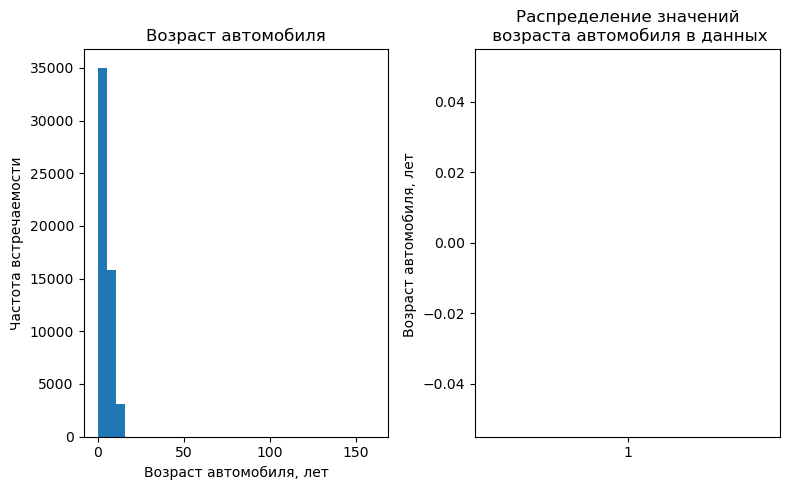

In [103]:
fig, ax = plt.subplots(1,2, figsize=(8,5))
ax[0].hist(data_for_model_2['vehicle_age'], bins=30)
ax[0].set_xlabel('Возраст автомобиля, лет')
ax[0].set_ylabel('Частота встречаемости')
ax[0].set_title('Возраст автомобиля')
ax[1].boxplot(data_for_model_2['vehicle_age'])
ax[1].set_ylabel('Возраст автомобиля, лет ')
ax[1].set_title('Распределение значений\n возраста автомобиля в данных')
plt.tight_layout()
plt.show()  

Ограничим данные 15 годами, при этом сохраним пропуски, которые потом заполним медианой.

In [104]:
data_for_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55647 entries, 0 to 56247
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   county_city_location  55647 non-null  object        
 1   county_location       55647 non-null  object        
 2   distance              55647 non-null  float64       
 3   direction             55647 non-null  object        
 4   intersection          55647 non-null  float64       
 5   weather_1             55647 non-null  object        
 6   location_type         55647 non-null  object        
 7   road_surface          55647 non-null  object        
 8   road_condition_1      55647 non-null  object        
 9   lighting              55647 non-null  object        
 10  control_device        55647 non-null  object        
 11  collision_time        55647 non-null  datetime64[ns]
 12  vehicle_transmission  55647 non-null  object        
 13  at_fault             

#### Виновность участника ДТП (целевая переменная)

In [105]:
data_for_model_2['at_fault'].value_counts()

at_fault
1    28045
0    27602
Name: count, dtype: int64

Количество классов в данных схожее. Есть совсем небольшой перекос в сторону класса 0 (не виновен в ДТП).

#### Удаление признаков

Удалим признаки, которые не пригодятся в модели.

In [106]:
data_for_model_2 = data_for_model_2.drop(columns=['collision_time'])
data_for_model_2 = data_for_model_2.drop(columns=['collision_hour'])

In [107]:
data_for_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55647 entries, 0 to 56247
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_city_location  55647 non-null  object 
 1   county_location       55647 non-null  object 
 2   distance              55647 non-null  float64
 3   direction             55647 non-null  object 
 4   intersection          55647 non-null  float64
 5   weather_1             55647 non-null  object 
 6   location_type         55647 non-null  object 
 7   road_surface          55647 non-null  object 
 8   road_condition_1      55647 non-null  object 
 9   lighting              55647 non-null  object 
 10  control_device        55647 non-null  object 
 11  vehicle_transmission  55647 non-null  object 
 12  at_fault              55647 non-null  int64  
 13  cellphone_in_use      55647 non-null  float64
 14  vehicle_type          55647 non-null  object 
 15  vehicle_age           53

### Вывод:<a id='4c'></a> 
В процессе подготовки данных для дальнейшего моделирования было сделано:
* SQL запрос для выгрузки данных по условию заказчика: взяты данные 2012 год, оставлен только тип участника ДТП автомобиль, убраны данные с незначительными поврежденими scratch
* проведен отбор признаков, на которых может быть основано предсказание модели
* отобранные признаки обработаны: удалены пропуски, укрупнены категории, удалены выбросы в количественных данных.
  
В ходе обработки было потеряно около 18% данных.  
Итого в модель отобрано 17 признаков.

### Корреляционный анализ<a id='4d'></a> 

Дополнительно проведем корреляционный анализ между признаками, будем использовать библиотеку phik.

In [108]:
data_for_model_2.columns.tolist()

['county_city_location',
 'county_location',
 'distance',
 'direction',
 'intersection',
 'weather_1',
 'location_type',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'vehicle_transmission',
 'at_fault',
 'cellphone_in_use',
 'vehicle_type',
 'vehicle_age',
 'time_of_day']

In [109]:
for_corr = data_for_model_2[['county_city_location',
                           'county_location',
                           'distance',
                           'direction',
                           'intersection',
                           'weather_1',
                           'location_type',
                           'road_surface',
                           'road_condition_1',
                           'lighting',
                           'control_device',
                           'vehicle_transmission',
                           'cellphone_in_use',
                           'vehicle_type',
                           'vehicle_age',
                           'time_of_day',
                           'at_fault']]

In [110]:
phik_overview = for_corr.phik_matrix(interval_cols=['distance',
                                                    'vehicle_age',
                                                    ])

/var/folders/bt/205ky3fd1092qkbczfc383cr0000gn/T/ipykernel_40463/2619108244.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


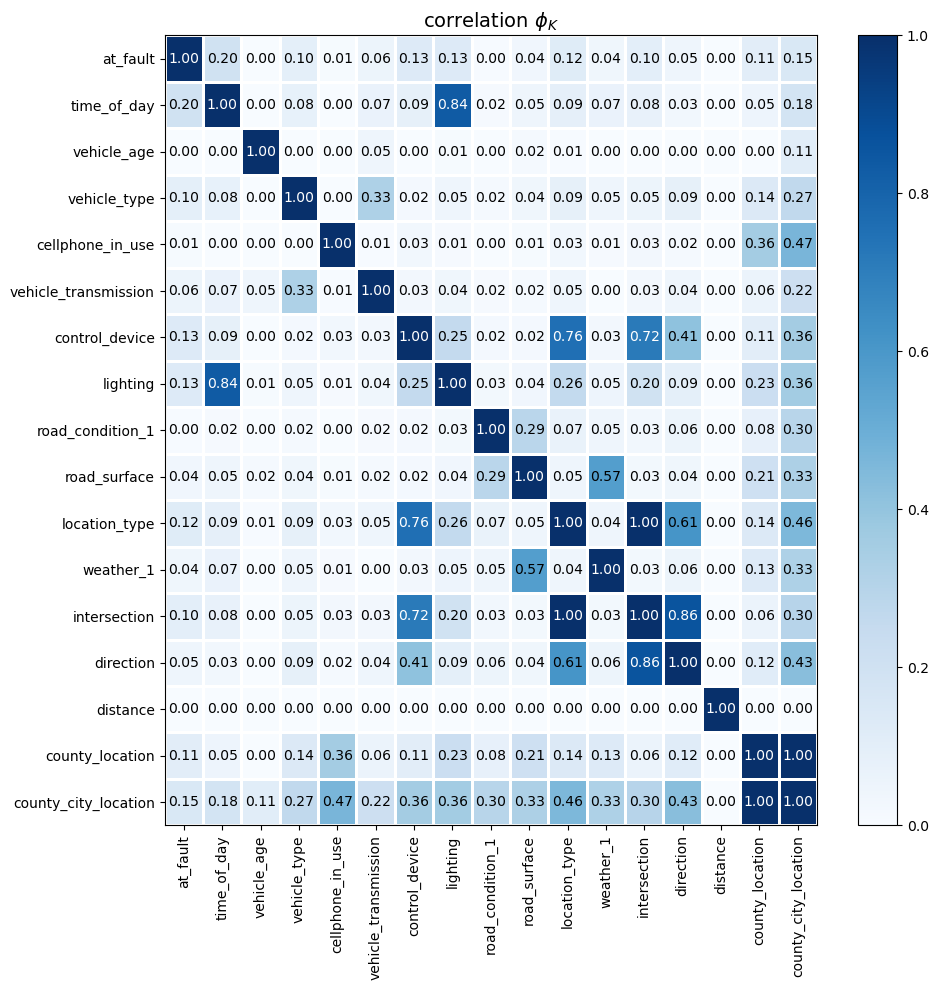

In [111]:
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0,
    vmax=1,
    color_map='Blues',
    title=r'correlation $\phi_K$',
    fontsize_factor=1,
    figsize=(10,10)
)
plt.tight_layout()

Признаков, хорошо скоррелированных с целевой переменной, нет. Можно заранее предположить, что с такими признаками будет тяжело предсказать целевую переменную.  
County location и county_city_location, как и предполагалось, мультиколлинеарные признаки. Удалим признак county_city_location, так как там намного больше категорий и его тяжелее обработать. Кроме того, мультколлинеарны признаки intersection и location_type. Удалим intersection, так как он хуже коррелирует с целевой переменной.

ВАЖНЫЙ ВЫВОД:  

<a id='4e'></a> 
После предаброботки и корреляционного анализа данных мы можем сделать существенный вывод. Первичное предложение заказчика не состоятельно. Изначальной целью заказчика было оценить ДТП по выбранному маршруту движения. Но целевая переменная это виновность водителя в ДТП. Поэтому мы не наблюдаем корреляции между большенством признаков, которые описывают маршрут движения и целевой переменной. Единственные признаки, которые показали хоть какую-то корреляцию, это признаки, которые описывают состояние водителя.

Далее возможно три пути:
* продолжить построение модели с имеющимися признаками и показать заказчику, что его предложение не состоятельно
* сменить задачу. Вернуть часть признаков, которые описывают само ДПТ. Сделать модель, которая будет предсказывать виновен ли водитель. Но такая система противоречит закону, виновность может быть установлена только в судебном порядке. Такая система может использоваться закрыто, внутри каршеринговой компании. Система позволит оценить риск водителя. Если водитель потенциально может быть виновником ДТП, то машину ему необходимо выдавать с осторожностью. Система аналогичная страхованию: есть ДТП с виной водителя - цена страховования выше. С другой стороны, не очень понятно зачем это нужно, ведь достаточно загрузить данные протокола с места ДТП и заключение о виновники аварии.
* сменить целевой признак. Например, сделать целевой переменной серьзность ДТП, вернув в данные признак 'царапины'. Такая целевая переменная косвенно помогла бы оценить сложность и аварийность маршрута.

Так как возможности проконсультроваться с заказчиком нет, останемся на первом пути и продемонстрируем заказчику, что адекватная модель не получится.

## Обучение моделей <a id='5'></a> 

Исключим столбец county_city_location и intersection.

In [112]:
data_for_model_2 = data_for_model_2.drop(columns=['county_city_location'])
data_for_model_2 = data_for_model_2.drop(columns=['intersection'])

Будем использовать три модели: Логистическую регрессию, Деревья решений и одну модель с градиентным бустингом (LGBMClassifier). Для подбора гиперпараметров моделей организуем пайплайн.      
Категориальные переменные с количеством значений больше трех закодируем в target_encoder, с меньшим в OneHotEncoder.      
Для стандартизации количественных признаков будем использовать MinMaxScaler и StandardScaler.      
При обучении бедем использовать кроссвалидацию и grid_search для перебора гиперпараметров. Если время обучения будет слишком долгое, возьмем random_search.  

Для оценки модели будем использовать F1-score.   
Данная метрика подходит, так как для нас имеет значение баланс между точностью и полнотой предсказания.   
Точность в данном контексте означает, что если система предсказала, что водитель виновен в ДТП, то вероятность того, что он действительно виновен, должна быть высокой. Хорошая точность поможет избежать ложных тревог, т.е. предупреждений, которые не соответствуют действительности.
Полнота будет измерять, насколько хорошо система выявляет все случаи, когда водитель действительно виновен в ДТП. Система должна не пропускать высокорисковые случаи, где вероятность аварии велика, и водитель на самом деле виновен. Это позволит не упустить важные риски.

In [113]:
data_for_model_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55647 entries, 0 to 56247
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   county_location       55647 non-null  object 
 1   distance              55647 non-null  float64
 2   direction             55647 non-null  object 
 3   weather_1             55647 non-null  object 
 4   location_type         55647 non-null  object 
 5   road_surface          55647 non-null  object 
 6   road_condition_1      55647 non-null  object 
 7   lighting              55647 non-null  object 
 8   control_device        55647 non-null  object 
 9   vehicle_transmission  55647 non-null  object 
 10  at_fault              55647 non-null  int64  
 11  cellphone_in_use      55647 non-null  float64
 12  vehicle_type          55647 non-null  object 
 13  vehicle_age           53974 non-null  float64
 14  time_of_day           55647 non-null  object 
dtypes: float64(3), int64(1),

In [114]:
# задаем параметры для разделения данных
RANDOM_STATE = 42
TEST_SIZE = 0.3
#разбиваем данные на выборки
X_train, X_test, y_train, y_test = train_test_split(
    data_for_model_2.drop(columns=['at_fault']), # X
    data_for_model_2['at_fault'], # y
    test_size = TEST_SIZE,
    random_state = RANDOM_STATE
)

mask = (X_train['vehicle_age'] <= 15) & (X_train['distance'] <= 1000)
X_train = X_train[mask]
y_train = y_train[mask]

In [115]:
# определяем списки на кодировани
traget_enc_col = ['county_location', 
                  'direction', 
                  'weather_1', 
                  'location_type', 
                  'lighting', 
                 'time_of_day']
ohe_col = ['road_surface', 
           'road_condition_1', 
           'control_device', 
           'vehicle_transmission', 
           'cellphone_in_use', 
           'vehicle_type']
num_col = ['distance',
           'vehicle_age']

# начинаем подготовку pipeline
ohe_pipe = Pipeline(
    [('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]
)
# используем параметр сглаживания, так как в признаках есть редкие категории
target_pipe = Pipeline(
    [('target_encoder', TargetEncoder(smooth='auto', target_type = 'continuous'))]
)
# обработка числовых признаков
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Заполнение пропусков медианой
    ('scaler', MinMaxScaler())  # Масштабирование
])

# создаем общий пайплайн для подготовеи данных
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_col),
     ('target_encoder', target_pipe, traget_enc_col),
     ('num', num_pipe, num_col)]
)

# создаем итоговый пайплайн
pipe_final = Pipeline(
    [('preprocessor', data_preprocessor),
     ('models', DecisionTreeClassifier())]
)

In [116]:
# создаем словари моделей
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range (2, 10),
        'models__max_features': range (3, 7),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],  
        'preprocessor__target_encoder': [target_pipe],
        'preprocessor__ohe':[ohe_pipe]
    },

    # словарь для модели SVC()

    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range (1, 5),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
        'preprocessor__target_encoder': [target_pipe],
        'preprocessor__ohe':[ohe_pipe]
    },

# словарь для модели LightGBM
    {
        'models': [lgb.LGBMClassifier(random_state=RANDOM_STATE)],
        'models__num_leaves': [15, 31, 60, 80],
        'models__max_depth': [12, -1],     
        'models__learning_rate': [0.01, 0.1, 0.2],  
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler()],
        'preprocessor__target_encoder': [target_pipe],
        'preprocessor__ohe': [ohe_pipe]
    }
    
]
# будем использовать grid_search

grid_search = GridSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    error_score='raise',
)

grid_search.fit(X_train, y_train)

print('Лучшая модель и её параметры:\n\n', grid_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', grid_search.best_score_)
print('Лучшие гиперпараметры модели:', grid_search.best_params_)

/Users/dima/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dima/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dima/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dima/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/dima/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/utils/deprec

[LightGBM] [Info] Number of positive: 15045, number of negative: 15637
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 465
[LightGBM] [Info] Number of data points in the train set: 30682, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.490353 -> initscore=-0.038594
[LightGBM] [Info] Start training from score -0.038594
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                              

Выведем информацию о пяти лучших моделях.

In [117]:
model_result = pd.DataFrame(grid_search.cv_results_)
model_result = model_result.sort_values(['rank_test_score'])
pd.set_option('display.max_colwidth', None)
model_result[['rank_test_score',
               'mean_test_score', 
               'rank_test_score', 
               'params']].head(5)

,rank_test_score,mean_test_score,rank_test_score,params
89,1,0.558966,1,"{'models': LGBMClassifier(random_state=42), 'models__learning_rate': 0.1, 'models__max_depth': 12, 'models__num_leaves': 15, 'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__ohe': (OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__target_encoder': (TargetEncoder(target_type='continuous'))}"
97,2,0.558518,2,"{'models': LGBMClassifier(random_state=42), 'models__learning_rate': 0.1, 'models__max_depth': -1, 'models__num_leaves': 15, 'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__ohe': (OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__target_encoder': (TargetEncoder(target_type='continuous'))}"
115,3,0.558438,3,"{'models': LGBMClassifier(random_state=42), 'models__learning_rate': 0.2, 'models__max_depth': -1, 'models__num_leaves': 31, 'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__ohe': (OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__target_encoder': (TargetEncoder(target_type='continuous'))}"
96,4,0.557777,4,"{'models': LGBMClassifier(random_state=42), 'models__learning_rate': 0.1, 'models__max_depth': -1, 'models__num_leaves': 15, 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__ohe': (OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__target_encoder': (TargetEncoder(target_type='continuous'))}"
88,5,0.557592,5,"{'models': LGBMClassifier(random_state=42), 'models__learning_rate': 0.1, 'models__max_depth': 12, 'models__num_leaves': 15, 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__ohe': (OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__target_encoder': (TargetEncoder(target_type='continuous'))}"


In [118]:
#добавляем столбей только с названием модели
model_result['model'] = model_result['param_models'].apply(lambda x: str(x).split('(')[0])

In [119]:
#группитруем
results_by_model = model_result.groupby('model').agg({
    'mean_test_score': 'max', 
    'params': 'first'   
}).reset_index().sort_values(by='mean_test_score', ascending=False)	

In [120]:
results_by_model

,model,mean_test_score,params
1,LGBMClassifier,0.558966,"{'models': LGBMClassifier(random_state=42), 'models__learning_rate': 0.1, 'models__max_depth': 12, 'models__num_leaves': 15, 'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__ohe': (OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__target_encoder': (TargetEncoder(target_type='continuous'))}"
2,LogisticRegression,0.554816,"{'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear'), 'models__C': 4, 'preprocessor__num__scaler': StandardScaler(), 'preprocessor__ohe': (OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__target_encoder': (TargetEncoder(target_type='continuous'))}"
0,DecisionTreeClassifier,0.554686,"{'models': DecisionTreeClassifier(random_state=42), 'models__max_depth': 9, 'models__max_features': 3, 'preprocessor__num__scaler': MinMaxScaler(), 'preprocessor__ohe': (OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)), 'preprocessor__target_encoder': (TargetEncoder(target_type='continuous'))}"


Все пять лучших моделей это модели градиентного бустинга с разными гиперпараметрами. Значение метрики F1 на ~~обучающей выборке~~ кросс валидации у лучшей модели составило 0.57, это очень низкий показатель. К сожалению это связано с тем, что данные не подходят для поставленной задачи.

Проверим работу лучшей модели на тестовой выборке.

In [121]:
y_pred = grid_search.best_estimator_.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

F1-score: 0.5794627497684266


/Users/dima/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


На тестовой выборке метрика сопоставимая.

In [122]:
# задаем параметры модели
dummy_clf = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE)
# обучаем
dummy_clf.fit(X_train, y_train)
# предсказываем
y_pred_dummy = dummy_clf.predict(X_test)
dummy_score = f1_score(y_test, y_pred_dummy)
print("F1-score для Dummy:", dummy_score)

F1-score для Dummy: 0.4929001203369434


### Матрица ошибок <a id='6'></a> 

In [123]:
conf_m = confusion_matrix(y_test, y_pred)

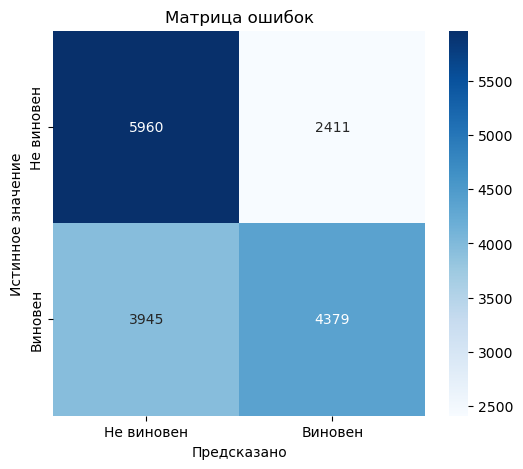

In [124]:
plt.figure(figsize=(6, 5))
sb.heatmap(conf_m, annot=True, fmt="d", cmap="Blues", xticklabels=["Не виновен", "Виновен"], yticklabels=["Не виновен", "Виновен"])
plt.xlabel("Предсказано")
plt.ylabel("Истинное значение")
plt.title("Матрица ошибок")
plt.show()

Из матрицы ошибок видно, что модель достаточно хорошо справляется с предсказанием класса 0 (невиновные водители). У модели неплохая точность, т.к. мало случаев, когда модель ошибается, считая невиновных водителей виновными.   
Но модель плохо предсказывает класс 1 (виновность водителя). Т.е. полнота предсказания низкая, много виновных водителей классифицируется как невиновные. Система не может выделить риск ДТП.

Такая система не может работать как система оценки рисков на маршруте.

Дополнительно визуализируем результат, используя кривую соответствия precisions и recalls.

/Users/dima/anaconda3/envs/ds_practicum_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


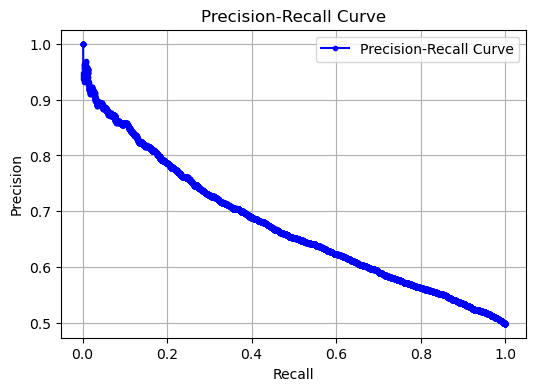

In [125]:
y_scores = grid_search.best_estimator_.predict_proba(X_test)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

plt.figure(figsize=(6, 4))
plt.plot(recalls, precisions, marker=".", label="Precision-Recall Curve", color="blue")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()

Из кривой видно, что при увеличении полноты, точность модели сильно падает, модель плохо справляется с разделением классов.

## Анализ важности факторов ДТП <a id='7'></a>

Так как лучшей оказалась модель LGBMClassifier, важность признаков можно получить, используя feature_importances_.

In [126]:
# получаем модель 
best_model = grid_search.best_estimator_.named_steps['models']

In [127]:
# получаем важность признаков
feature_importance = best_model.feature_importances_

In [128]:
# так как было кодирование, необходимо восстановить название признаков
# получаем назыание признаков
feature_names = grid_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
# собираем все в DataFrame
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})

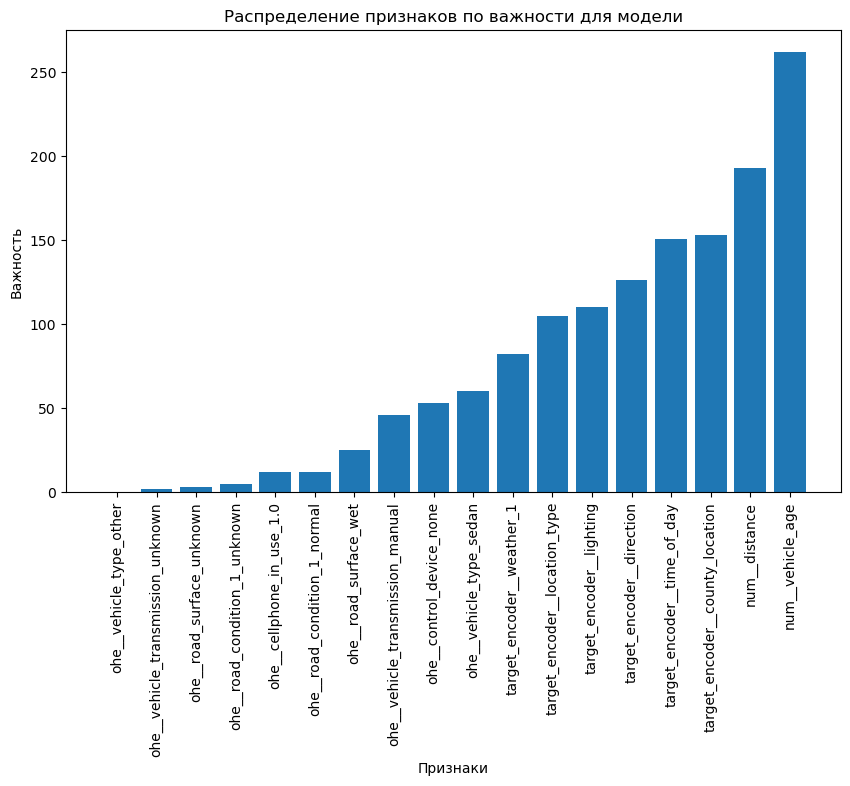

In [129]:
feature_importance_df = feature_importance_df.sort_values(by='importance')
plt.figure(figsize=(10,6))
plt.bar(feature_importance_df['feature'],feature_importance_df['importance'])
plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Распределение признаков по важности для модели')
plt.xticks(rotation=90)
plt.show()
        

Наиболее важным для модели оказался признак местоположение ДТП. Важность такого признака можно объсянить тем что, например, в местах с меньшим трафиком, меньше ДТП. Второй признак - дистанция до перекрестка. Третий признак это время, что согласуется с анализом, проведенным ранее по данным за предыдущие годы.  
Проанализируем первый по важности признак и постараемся понять, почему он оказался столь выжным для модели.

** изначально модель выдавала как наиболее важный признак county_location, но когда я сделал перезапуск перед отправкой, признаки distance и county_location поменялись местами.

#### Признак местоположение ДТП <a id='7a'></a>

Рассчитаем процентное соотношение категорий для каждого местоположения

In [130]:
percentage = data.groupby('county_location')['at_fault'].value_counts(normalize=True).unstack()*100

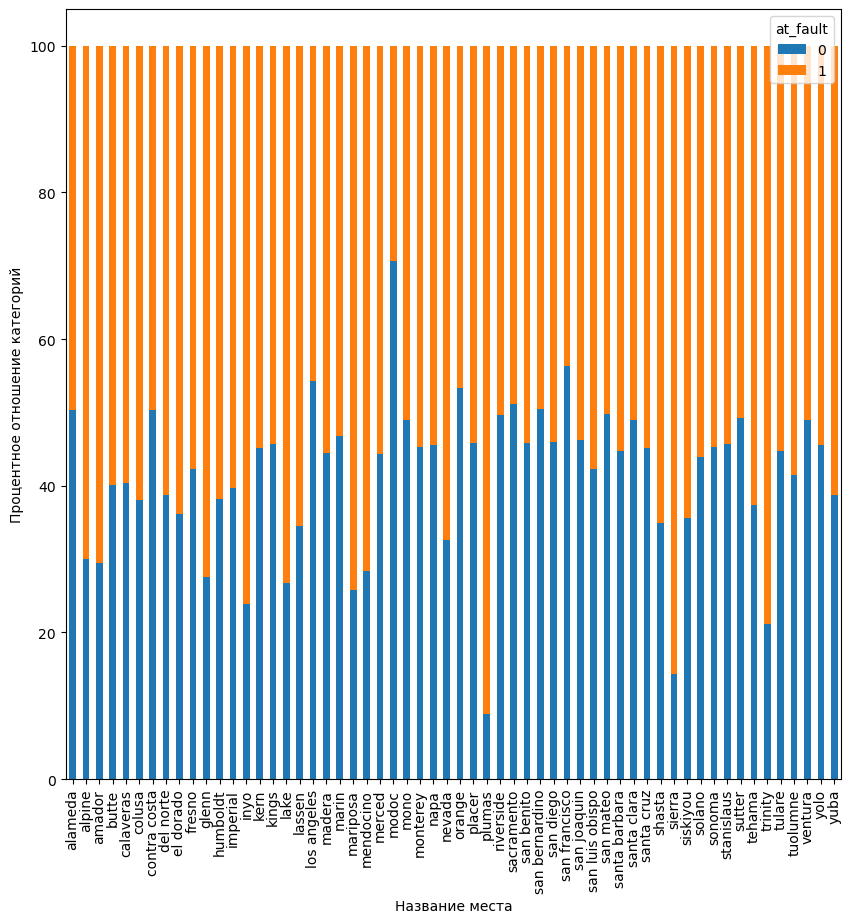

In [131]:
percentage.plot(kind='bar', stacked=True, figsize=(10, 10))
plt.xlabel('Название места')
plt.ylabel('Процентное отношение категорий')
plt.show()

Видно, что процентное соотношение колеблится около 50% процентов, но есть города, где наблюдается перевес той или иной группы. Например, в plumas больше виновников ДТП, а в modoc меньше.

#### Рекомендация <a id='7b'></a>

Три наиболее важных признака для модели это место положения, расстояние до перекрестка и время. Далее, после возраста авто, также идут признаки, связанные с местоположением автомобиля и временем. Если принять эту модель, чего на самом деле не стоит делать, то машины необходимы оснастить современными точными GPS навигаторами, которые анализировали местоположение автомобиля в зависимости от времени. С навигатором можно было бы связать какие-нибудь автоматические системы контроля управления. Как, например, для самокатов, которым нельзя привышать порог скорости в определенных зонах.

## Выводы <a id='8'></a>

При выполнении проекта было сделано следующее:  
* Был сделан SQL запрос и получены необходимые данные
* Были отобраны признаки, на которых можно оценить риск движения по маршруту.
* Исключены признаки, которые описывают уже состоявшееся ДТП.
* Выполнена предобработка отобранных признаков.
* Проведен корреляционный анализ
* После корреляционного анализа выявлена некорректная постановка задачи заказчиком. Большая часть признаков, которые описывают заданный маршрут, очень плохо коррелируют с целевым признаком. Заказчик предлагал оценить риск ДТП на маршруте, исходя из виновности водителя в ДТП. Для полной реализации задачи необходимы данные о тех водителях, которые проехали маршруты без происшествий.
* Было предложено три пути дальнейшего выполнения проекта.  
   * продолжить работать по заданному курсу
   * сменить задачу
   * сменить целевую переменную
Из-за невозможности получить консультацию заказчика, было принято решение работать дальше по заданному ранее плану.
* Был проведен подбор модели. Лучший результат показала модель градиентного бустинга LGBM. В качестве метрики качества выбрали F1-score. Метрика показала очень малый результат как на обучающей, так и на тестовой выборках.
* Дальнейший анализ модели показал, что модель обладает неплохой точностью, но слабой полнотой. Т.е. модель неплохо предсказывает невиновных водителей, но плохо предсказывает виновных водителей.
* Анализ важности признаков показа, что наиболее важными признаками являются признаки, связанные с местоположение.

На данный момент модель не предсказывает риск маршрута, модель скорее пытается предсказать, как водитель среагирует на независящие от него причины. Например, если дорога мокрая и водитель виновник ДТП, это может косвенно указывать на то, что он не оценил погодные условия. Или водитель не оценил сложность движения в определенном месте он виновник ДТП, а если правильно сориентировался, то не виновник.

В модели не хватает данных о проездах маршрутов без ДТП. Из имеющихся данных можно было бы попробовать оценить риск, используя в качестве целевой переменной степень повреждения. При этом не было бы группы без ДТП, но мы могли бы оценивать, где машины просто поцарапались, а где произошло серьезное столкновение лоб в лоб. А это совсем разные финансовые затраты на ремонт автомобилей.